Importing Dataset

In [1]:
%tensorflow_version

Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x


Disabling eager execution

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

Importing Essentials

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib.cm import get_cmap

Initializing :
We will be using alpha-beta rule for lower layers and some middle layer
1.   Using stabalising variable epsilon with alpha-beta rule as per epsilon rule:<br>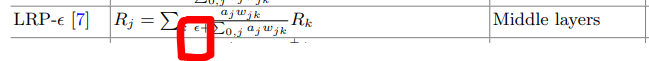
2.   Alpha Beta Rule for middle and lower layer till just before input:<br>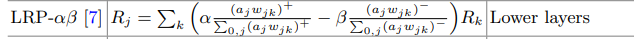
\n ref : https://link.springer.com/chapter/10.1007/978-3-030-28954-6_10#:~:text=LRP%2D0%20%5B7,First%20layer%20(pixels)

#**LRP**
Basic rules:<br>
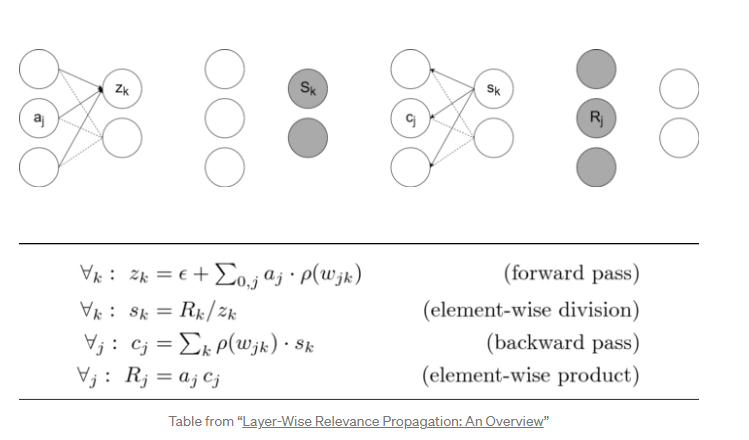
<br>
rule 0:<br>
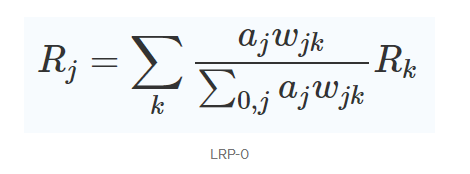
<br>
ref: https://towardsdatascience.com/indepth-layer-wise-relevance-propagation-340f95deb1ea

General steps
<br>
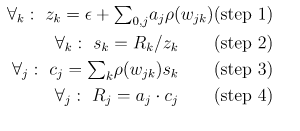

Pseudocode
<br>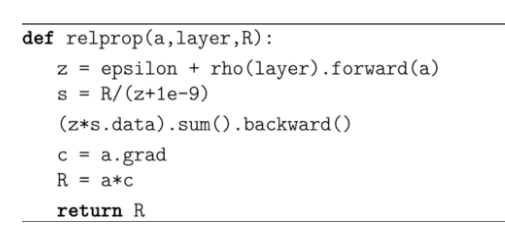

Step 3 using gradient
<br>
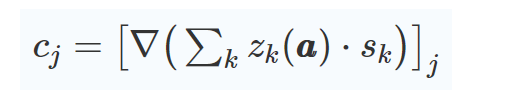


In [4]:
model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), weights="imagenet")

553476096/553467096 [==============================] - 6s 0us/step


In [30]:
import tensorflow.keras.backend as K
from tensorflow.python.ops import gen_nn_ops
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np 

class RelevancePropagation(object):
    """
    This LRP implementation is using 
    1. LRP-0/ LRP-Epsilon for higher layers
    2. LRP-Alpha-Beta for lower layers
    """

    def __init__(self, model):
        '''
        Model to perform LRP
        '''
        self.epsilon = 1.0e-9
        #self.rule = "z_plus"
        #self.pooling_type = "avg"
        #self.grayscale = True
        self.alpha = 0.7
        self.beta = 1-self.alpha
        self.model = model

        # Load model
        input_shape = (224, 224, 3)
        #network = "vgg16"
        #weights = "imagenet"

        '''
        if network == "vgg16":
            self.model = tf.keras.applications.VGG16(input_shape=input_shape, weights=weights)
        elif network == "vgg19":
            self.model = tf.keras.applications.VGG19(input_shape=input_shape, weights=weights)
        else:
            raise Exception("Error: Unknown network name.")
        '''

        train_layer_names = [x.name for x in self.model.layers if ('conv' in x.name) or ('fc' in x.name) or ('predictions' in x.name)]
        train_layer_weights = [weight for weight in self.model.trainable_weights if 'bias' not in weight.name]

        # Extract weights
        self.weights = {name : weight for name, weight in zip(train_layer_names, train_layer_weights)}

        # Extract activation layers
        self.activations = [layer.output for layer in self.model.layers]
        self.activations = self.activations[::-1]

        # Extract layers name
        self.layer_names = [layer.name for layer in self.model.layers]
        self.layer_names = self.layer_names[::-1]
        
        # Build relevance graph
        self.relevance = self.relevance_propagation()

    def run(self, image, split_ch = 0):
        """
        Executes LRP
        Args:
            image: array of shape (W, H, C)
        Returns:
           grayscale relevance map.
        """

        f = K.function(inputs=self.model.input, outputs=self.relevance)
        image = preprocess_input(image)
        image = tf.expand_dims(image, axis=0)
        relevance_scores = f(inputs=image)
        relevance_scores = self.postprocess(relevance_scores, split_ch)
        return np.squeeze(relevance_scores)

    def relevance_propagation(self):
        """
        Propogates Relevance upto input
        """
        relevance = self.model.output

        for i, layer_name in enumerate(self.layer_names):


            '''
            We will use only positive of higher layers to propogate to lowere layer
            And both positive and negative for lowere layers
            '''
            if i < int(len(self.layer_names)/2) :
                dap = 0

            if i > int(len(self.layer_names)/2):
                dap =  1

            if 'prediction' in layer_name:
                relevance = self.relprop_dense(self.activations[i+1], self.weights[layer_name], relevance)
            elif 'fc' in layer_name:
                relevance = self.relprop_dense(self.activations[i+1], self.weights[layer_name], relevance)
            elif 'flatten' in layer_name:
                relevance = self.relprop_flatten(self.activations[i+1], relevance)
            elif 'pool' in layer_name:
                relevance = self.relprop_pool(self.activations[i+1], relevance, dap)
            elif 'conv' in layer_name:
                relevance = self.relprop_conv(self.activations[i+1], self.weights[layer_name], relevance, layer_name, dap)
            elif 'input' in layer_name:
                pass
            else:
                raise Exception("Error: layer type not recognized.")
        return relevance

    def relprop_dense(self, activations, weights, relevance):
        """
        Implements relevance propagation rules for dense layers.
        Args:
            activations: array of activations
            weights: array of weights
            relevance: array of relevance scores
        Returns:
            array of relevance scores of same dimension as a
        """

        w_pos = tf.maximum(weights, 0.0)
        z_pos = tf.matmul(activations, w_pos) + self.epsilon
        s_pos = relevance / z_pos
        c_pos =  tf.matmul(s_pos, tf.transpose(w_pos))

        '''
        w_neg = tf.minimum(weights, 0.0)
        z_neg = tf.matmul(activations, w_neg) + self.epsilon
        s_neg = r / z_neg
        c_neg = tf.matmul(s_neg, tf.transpose(w_neg))
        '''

        return (self.alpha*c_pos) * activations
            

    def relprop_flatten(self, activations, relevance):
        """
        Transfers relevance scores coming from dense layers to feature maps of network.
        Args:
            activations: array of activations
            r: array of relevance scores
        Returns:
            array of relevance scores of same dimension as a
        """
        return tf.reshape(relevance, tf.shape(activations))

    def relprop_pool(self, activations, relevance, dap, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='SAME'):
        """
        Implements relevance propagation through pooling layers.
        Args:
            activations: array of activations
            relevance: array of relevance scores
            dap : Switch to indicate lower/higher layers of the network
            ksize: pooling kernel dimensions used during forward path
            strides: step size of pooling kernel used during forward path
            padding: parameter for SAME or VALID padding
        Returns:
            array of relevance scores of same dimensions as a
        """
        z = tf.nn.avg_pool(activations, ksize, strides, padding) 

        z_pos = tf.math.maximum(z, 0)+ self.epsilon
        s_pos = relevance / z_pos
        c_pos = tf.raw_ops.AvgPoolGrad(orig_input_shape = tf.shape(activations) , grad = s_pos, ksize=ksize, strides=strides, padding=padding)

        z_neg =  tf.math.minimum(z, 0)+ self.epsilon
        s_neg = relevance / z_neg
        c_neg = tf.raw_ops.AvgPoolGrad(orig_input_shape = tf.shape(activations) , grad = s_neg, ksize=ksize, strides=strides, padding=padding)


        if dap==1:
            return (self.alpha*c_pos-self.beta*c_neg) * activations

        if dap==0: 
            return c_pos* activations

    def relprop_conv(self, activations, weights, relevance, name, dap, strides=(1, 1, 1, 1), padding='SAME'):
        """Implements relevance propagation rules for convolutional layers.
        Args:
            activations: array of activations
            weights : array of weights
            relevance: array of relevance scores
            name: current layer name
            dap : Switch to indicate lower/higher layers of the network
            strides: step size of filters used during forward path
            padding: parameter for SAME or VALID padding
        Returns:
            array of relevance scores of same dimensions as a
        """
        if name == 'block1_conv1':
            hx = tf.ones_like(activations)  
            w_pos = tf.maximum(weights, 0.0)
            z_pos = tf.nn.conv2d(hx , w_pos, strides, padding) + self.epsilon
            s_pos = relevance / z_pos
            c_pos = tf.raw_ops.Conv2DBackpropInput(input_sizes = tf.shape(activations), filter = w_pos, out_backprop = s_pos, strides=[1,1,1,1], padding=padding)

            lx = hx*-1
            w_neg = tf.minimum(weights, 0.0)
            z_neg = tf.nn.conv2d(lx, w_neg, strides, padding) + self.epsilon
            s_neg = relevance / z_neg
            c_neg = tf.raw_ops.Conv2DBackpropInput(input_sizes = tf.shape(activations), filter = w_neg, out_backprop = s_neg, strides=[1,1,1,1], padding=padding)

            z = tf.nn.conv2d(activations, weights, strides, padding) + self.epsilon
            s = relevance / z
            c = tf.raw_ops.Conv2DBackpropInput(input_sizes = tf.shape(activations), filter = weights, out_backprop = s, strides=[1,1,1,1], padding=padding)

            return (c-self.alpha*c_pos-self.beta*c_neg) * activations


        w_pos = tf.maximum(weights, 0.0)
        z_pos = tf.nn.conv2d(activations, w_pos, strides, padding) + self.epsilon
        s_pos = relevance / z_pos
        c_pos = tf.raw_ops.Conv2DBackpropInput(input_sizes = tf.shape(activations), filter = w_pos, out_backprop = s_pos, strides=[1,1,1,1], padding=padding)

        if dap==1:
            w_neg = tf.minimum(weights, 0.0)
            z_neg = tf.nn.conv2d(activations, w_neg, strides, padding) + self.epsilon
            s_neg = relevance / z_neg
            c_neg = tf.raw_ops.Conv2DBackpropInput(input_sizes = tf.shape(activations), filter = w_neg, out_backprop = s_neg, strides=[1,1,1,1], padding=padding)
            return (self.alpha*c_pos-self.beta*c_neg) * activations

        if dap==0: 
            return c_pos* activations


    @staticmethod
    def rescale(x):
        """Rescales relevance scores of a batch of relevance maps between 0 and 1
        Args:
            x: RGB or grayscale relevance maps with dimensions (N, W, H, C) or (N, W, H), respectively.
        Returns:
            Rescaled relevance maps of same dimensions as input
        """
        x_min = np.min(x, axis=(1, 2), keepdims=True)
        x_max = np.max(x, axis=(1, 2), keepdims=True)
        return (x - x_min).astype("float64") / (x_max - x_min).astype("float64")

    def postprocess(self, x, split_ch = 0):
        """
        Postprocesses batch of feature relevance scores (relevance_maps).
        Args:
            x: array with dimension (N, W, H, C)
        Returns:
            x: array with dimensions (N, W, H)
        """
        #if self.grayscale:
        x = np.mean(x, axis=-1)

        x = self.rescale(x)

        return x

lrp = RelevancePropagation(model)

In [65]:
import urllib.request
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np 
from keras.applications.vgg16 import decode_predictions

url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Panor%C3%A1mica_Oto%C3%B1o_Alc%C3%A1zar_de_Segovia.jpg/800px-Panor%C3%A1mica_Oto%C3%B1o_Alc%C3%A1zar_de_Segovia.jpg"
urllib.request.urlretrieve(url, "Castle.jpg")

url = "https://cdn.the-scientist.com/assets/articleNo/66820/hImg/34886/bird-banner3-s.png"
urllib.request.urlretrieve(url, "bird.jpg")

('bird.jpg', <http.client.HTTPMessage at 0x7fb5b0b75c10>)

In [53]:
def XAI_plot(image_path, XAI ):
    image = load_img(image_path, target_size=(224, 224))
    image_array = img_to_array(image)
    XAI_img1 = XAI.run(image_array)

    y = model.predict(np.expand_dims(image_array, axis=0))
    label = decode_predictions(y)
    label = label[0][0]

    plt.subplot(1, 2, 1)
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.imshow(image_array)
    plt.title(f"{label[1]} - {round(label[2]*100, 2)}")

    plt.imshow(XAI_img1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


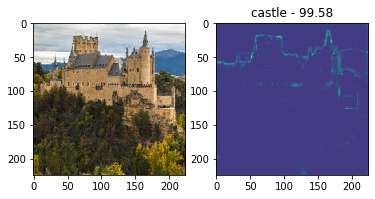

In [54]:
XAI_plot(image_path='Castle.jpg' , XAI = lrp )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


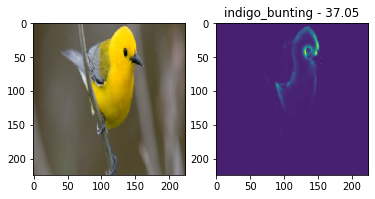

In [66]:
XAI_plot(image_path='bird.jpg' , XAI = lrp )